In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 0 1]


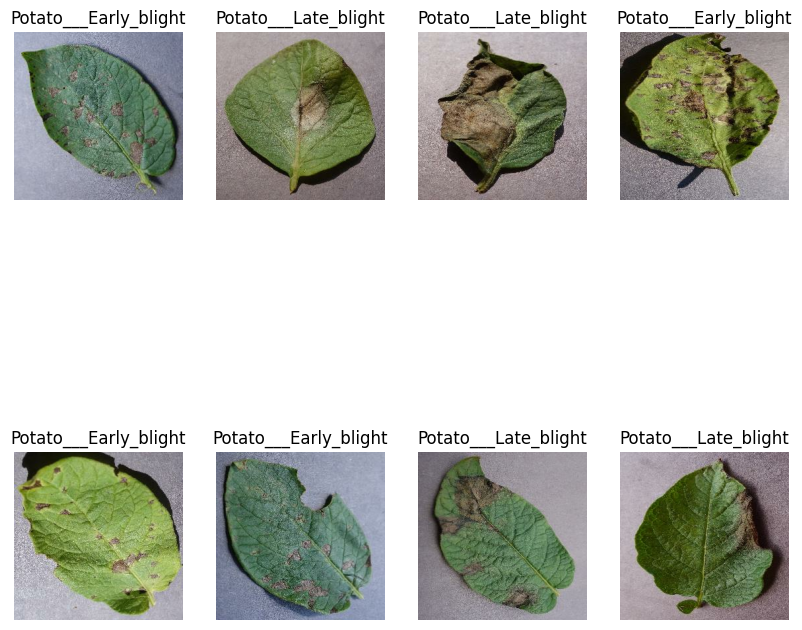

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
from tensorflow.keras.applications import InceptionV3

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22,328,099
Trainable params: 525,315
Non-trainable params: 21,802,784
____________________________________

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 75s 168ms/step - loss: 1.6385 - accuracy: 0.8692 - val_loss: 0.7430 - val_accuracy: 0.8750
Epoch 2/50
300/300 [==============================] - 29s 97ms/step - loss: 0.4950 - accuracy: 0.9212 - val_loss: 0.3957 - val_accuracy: 0.9155
Epoch 3/50
300/300 [==============================] - 30s 98ms/step - loss: 0.3540 - accuracy: 0.9333 - val_loss: 0.2744 - val_accuracy: 0.9561
Epoch 4/50
300/300 [==============================] - 30s 98ms/step - loss: 0.3241 - accuracy: 0.9275 - val_loss: 0.3973 - val_accuracy: 0.8986
Epoch 5/50
300/300 [==============================] - 30s 99ms/step - loss: 0.3097 - accuracy: 0.9371 - val_loss: 0.2485 - val_accuracy: 0.9628
Epoch 6/50
300/300 [==============================] - 32s 106ms/step - loss: 0.3206 - accuracy: 0.9308 - val_loss: 0.4323 - val_accuracy: 0.8682
Epoch 7/50
300/300 [==============================] - 31s 103ms/step - loss: 0.2703 - accuracy: 0.9450 - val_loss: 0.2338 - val_accura

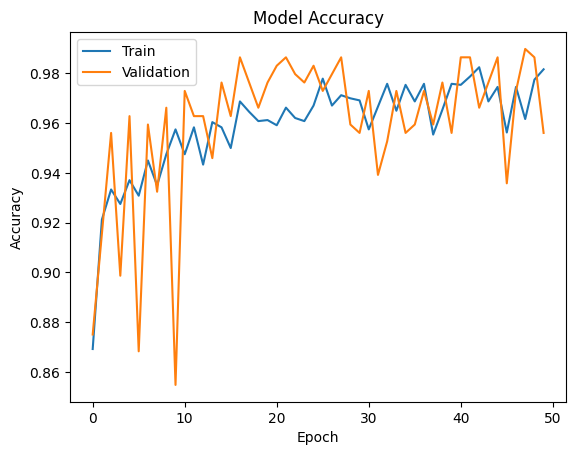

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

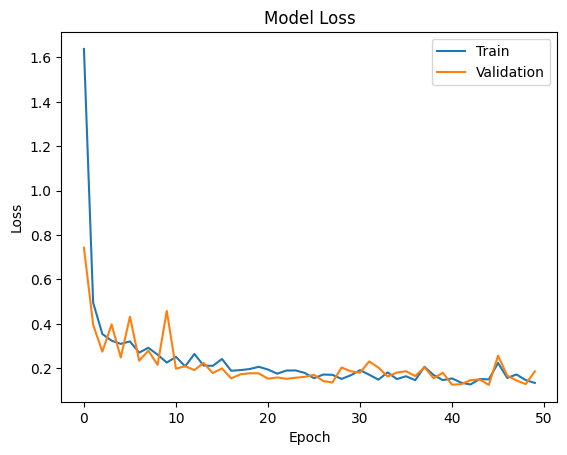

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

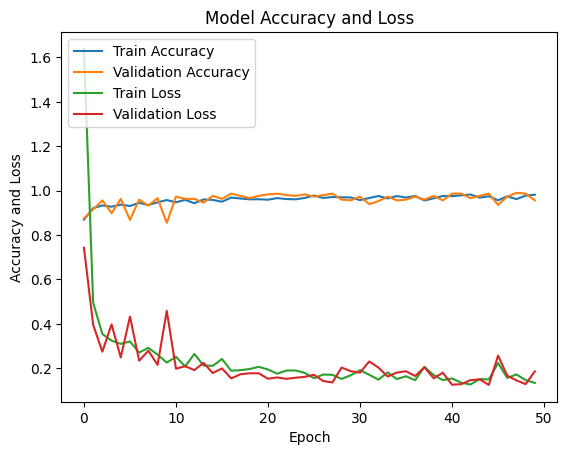

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 7s 77ms/step - loss: 0.1520 - accuracy: 0.9704


[0.8691666722297668,
 0.9212499856948853,
 0.9333333373069763,
 0.9275000095367432,
 0.9370833039283752,
 0.9308333396911621,
 0.9449999928474426,
 0.9350000023841858,
 0.9474999904632568,
 0.9574999809265137,
 0.9474999904632568,
 0.9583333134651184,
 0.9433333277702332,
 0.9604166746139526,
 0.9583333134651184,
 0.949999988079071,
 0.96875,
 0.9645833373069763,
 0.9608333110809326,
 0.9612500071525574,
 0.9591666460037231,
 0.9662500023841858,
 0.9620833396911621,
 0.9608333110809326,
 0.9670833349227905,
 0.9779166579246521,
 0.9670833349227905,
 0.9712499976158142,
 0.9700000286102295,
 0.9691666960716248,
 0.9574999809265137,
 0.9666666388511658,
 0.9758333563804626,
 0.9649999737739563,
 0.9754166603088379,
 0.96875,
 0.9758333563804626,
 0.9554166793823242,
 0.965416669845581,
 0.9758333563804626,
 0.9754166603088379,
 0.9787499904632568,
 0.9825000166893005,
 0.96875,
 0.9745833277702332,
 0.956250011920929,
 0.9745833277702332,
 0.9616666436195374,
 0.9775000214576721,
 0.9816

In [ ]:
history.history['val_accuracy']

[0.875,
 0.9155405163764954,
 0.9560810923576355,
 0.8986486196517944,
 0.962837815284729,
 0.8682432174682617,
 0.9594594836235046,
 0.9324324131011963,
 0.9662162065505981,
 0.8547297120094299,
 0.9729729890823364,
 0.962837815284729,
 0.962837815284729,
 0.9459459185600281,
 0.9763513803482056,
 0.962837815284729,
 0.9864864945411682,
 0.9763513803482056,
 0.9662162065505981,
 0.9763513803482056,
 0.9831081032752991,
 0.9864864945411682,
 0.9797297120094299,
 0.9763513803482056,
 0.9831081032752991,
 0.9729729890823364,
 0.9797297120094299,
 0.9864864945411682,
 0.9594594836235046,
 0.9560810923576355,
 0.9729729890823364,
 0.9391891956329346,
 0.9527027010917664,
 0.9729729890823364,
 0.9560810923576355,
 0.9594594836235046,
 0.9729729890823364,
 0.9594594836235046,
 0.9763513803482056,
 0.9560810923576355,
 0.9864864945411682,
 0.9864864945411682,
 0.9662162065505981,
 0.9763513803482056,
 0.9864864945411682,
 0.9358108043670654,
 0.9729729890823364,
 0.9898648858070374,
 0.986486

In [ ]:
history.history['loss']

[1.6384578943252563,
 0.49497345089912415,
 0.3540065884590149,
 0.3240889310836792,
 0.30968061089515686,
 0.32062846422195435,
 0.27032041549682617,
 0.29189932346343994,
 0.26119986176490784,
 0.2253488153219223,
 0.25108128786087036,
 0.20808735489845276,
 0.2642201781272888,
 0.21205225586891174,
 0.21054409444332123,
 0.2415720820426941,
 0.18850262463092804,
 0.19127987325191498,
 0.1962658315896988,
 0.20622269809246063,
 0.19402188062667847,
 0.17533697187900543,
 0.18943355977535248,
 0.18987219035625458,
 0.1785707175731659,
 0.15490183234214783,
 0.1713525801897049,
 0.1702062040567398,
 0.15177562832832336,
 0.16826723515987396,
 0.19109268486499786,
 0.17049457132816315,
 0.14835983514785767,
 0.18104876577854156,
 0.15099084377288818,
 0.16370974481105804,
 0.14607124030590057,
 0.206159770488739,
 0.16892562806606293,
 0.14621391892433167,
 0.15387912094593048,
 0.1347474902868271,
 0.12655536830425262,
 0.15114903450012207,
 0.14939221739768982,
 0.223666250705719,
 0.

In [ ]:
history.history['val_loss']

[0.742964506149292,
 0.39569902420043945,
 0.2743901014328003,
 0.3973310589790344,
 0.24845251441001892,
 0.43228214979171753,
 0.2337925136089325,
 0.2789698541164398,
 0.21490569412708282,
 0.4579267203807831,
 0.19769372045993805,
 0.20914122462272644,
 0.19137245416641235,
 0.2238510698080063,
 0.1782914251089096,
 0.19900591671466827,
 0.15415191650390625,
 0.17259372770786285,
 0.17716383934020996,
 0.17691120505332947,
 0.15261782705783844,
 0.1583104133605957,
 0.15212799608707428,
 0.15708929300308228,
 0.16101780533790588,
 0.17028437554836273,
 0.1422266811132431,
 0.13578663766384125,
 0.20297707617282867,
 0.1865420937538147,
 0.17997558414936066,
 0.23047485947608948,
 0.20286373794078827,
 0.1625552624464035,
 0.1803760677576065,
 0.18635688722133636,
 0.16461585462093353,
 0.20416401326656342,
 0.15456384420394897,
 0.17959722876548767,
 0.12552618980407715,
 0.1281786561012268,
 0.1461150050163269,
 0.1496579647064209,
 0.12465427070856094,
 0.2565698027610779,
 0.166

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9703947305679321
Loss:  0.15202367305755615


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

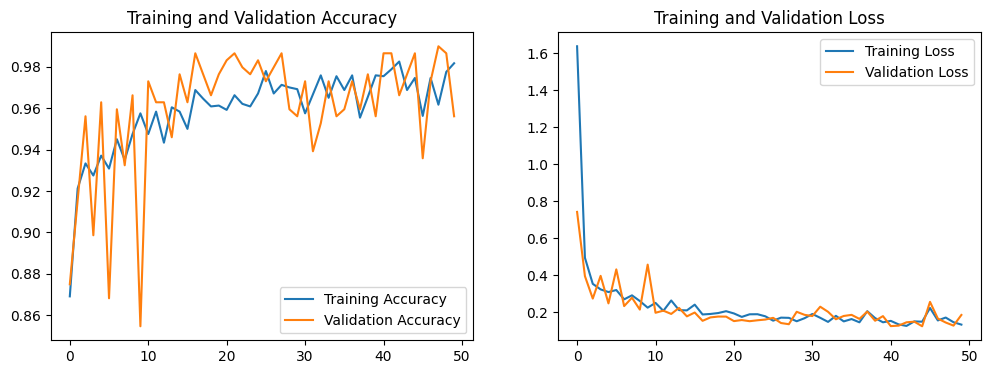

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 4s 4s/step
[1.5812556e-04 9.9982733e-01 1.4531695e-05]
Max Value: 1
Predicted Label: Potato___Late_blight


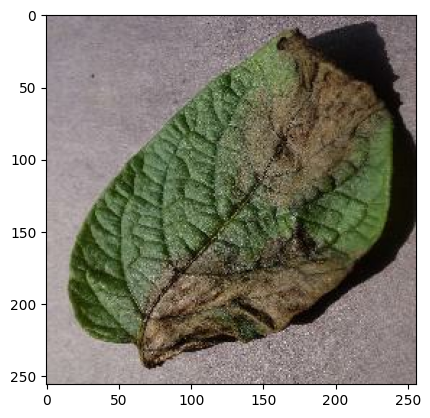

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


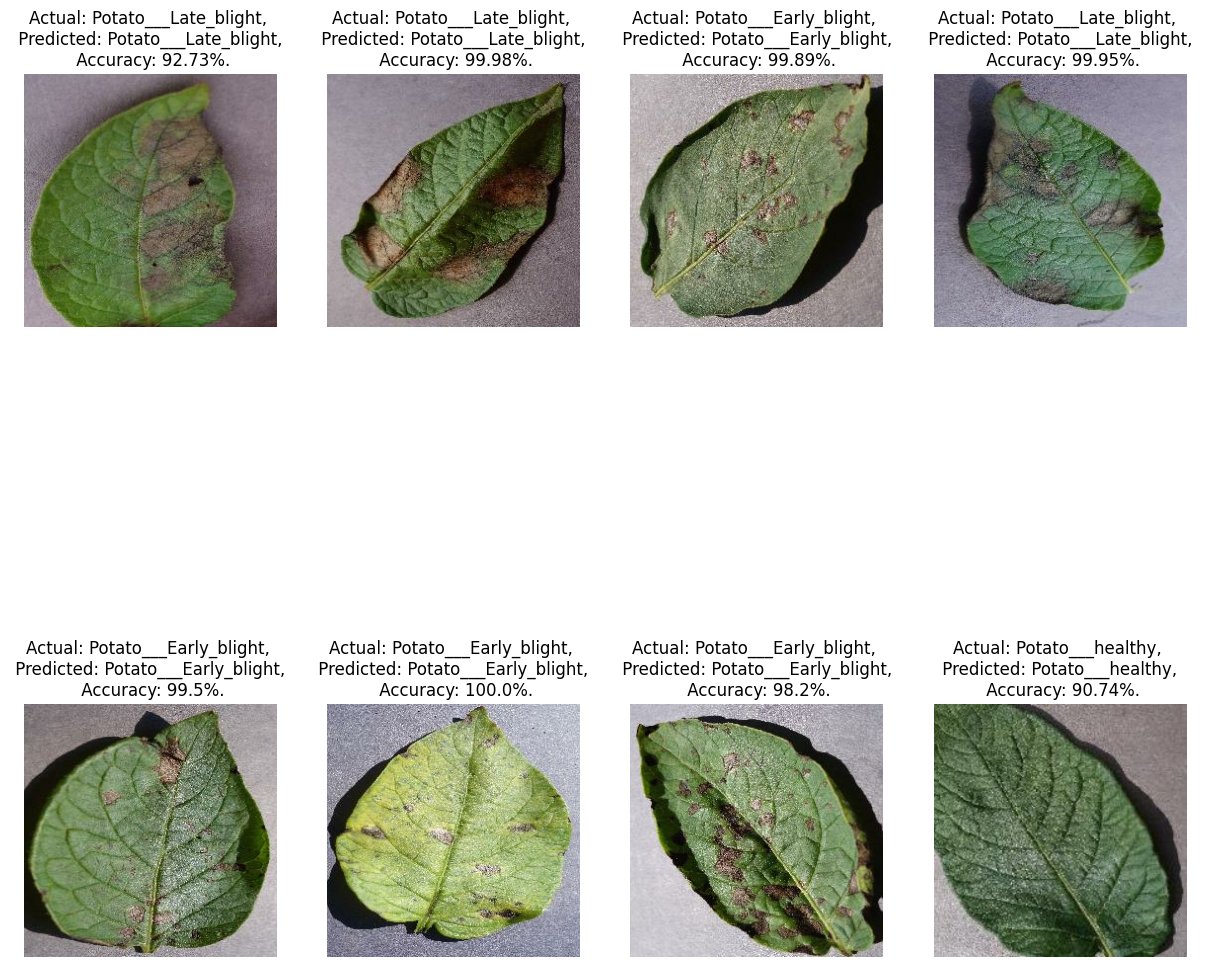

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  97.03947305679321


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 6s 67ms/step
F1 Score:  32.09099469817969
Precision Score:  31.984050526905563
Recall Score:  32.23684210526316


38/38 [==============================] - 3s 67ms/step


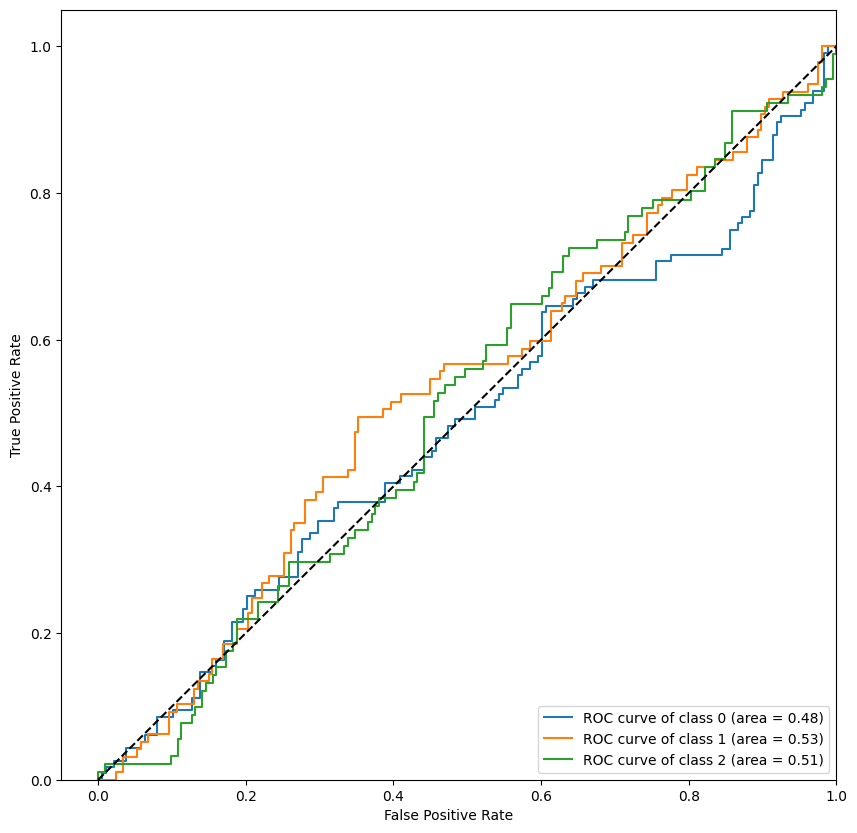

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 3s 71ms/step


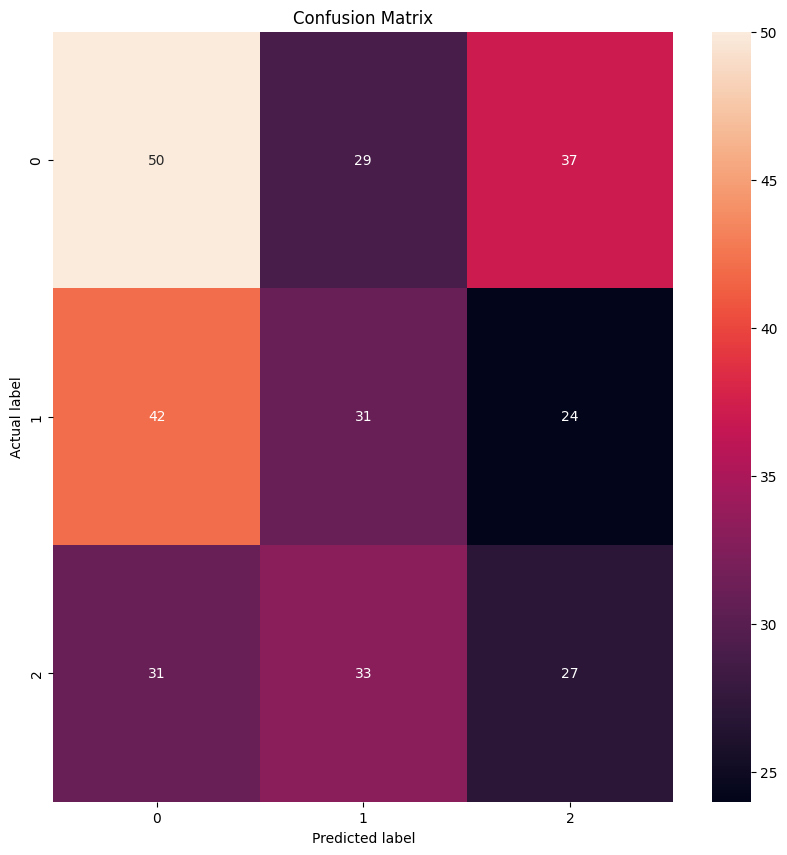

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()